# Monk1 
Grid Search for Monk1 dataset model selection


In [67]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk1
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk1 dataset 

In [68]:
training_data, training_labels, test_data, test_labels = read_monk1("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [69]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [70]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [71]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 32
epochs = 200

if not os.path.exists('monk1_models_configs.json'):
    dir_path = "Monk1/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True, number_of_initializations=2,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, all_models=True, num_models=100, workers=8
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json('monk1_models_configs.json')
else: 
    with open('monk1_models_configs.json', 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [81]:
models = []
with tqdm(total=len(configs)) as pbar:
    for config in configs:
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mee'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, model.history['mae'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


In [86]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['History_Std'] <= 0.11]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,History,Model,Config,Num_Layers,Num_of_Units,Name
25,0.000975,0.102909,1.0,0.001616,1.0,200,"[0.5041243, 0.5012288, 0.49399415, 0.48917964,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.54,...",1,[4],Model275535
15,0.000982,0.107864,1.0,0.001310,1.0,193,"[0.4965413, 0.48921975, 0.4832646, 0.4753223, ...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.53,...",1,[3],Model283852
43,0.001316,0.108820,1.0,0.001906,1.0,200,"[0.49995872, 0.49992365, 0.49985978, 0.4996777...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.56,...",1,[3],Model253300
74,0.001459,0.108854,1.0,0.002324,1.0,200,"[0.5109114, 0.50388306, 0.49237955, 0.47888002...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.58,...",1,[4],Model245935
99,0.001473,0.108956,1.0,0.001992,1.0,200,"[0.5037128, 0.49933058, 0.49555153, 0.49334118...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.59,...",1,[4],Model228975
81,0.002733,0.101936,1.0,0.004636,1.0,200,"[0.49647906, 0.5009938, 0.50084895, 0.4923698,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.58,...",1,[3],Model243213
13,0.009156,0.104958,1.0,0.016253,1.0,200,"[0.4972271, 0.4944565, 0.49083492, 0.4867097, ...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.53,...",1,[4],Model286727
49,0.000834,0.105221,1.0,0.001512,1.0,200,"[0.49860534, 0.49813375, 0.49746117, 0.4966344...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.56,...",2,"[3, 4]",Model252055
36,0.001238,0.103421,1.0,0.002148,1.0,200,"[0.5004701, 0.4987801, 0.4975563, 0.49636102, ...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.57,...",2,"[4, 4]",Model260382


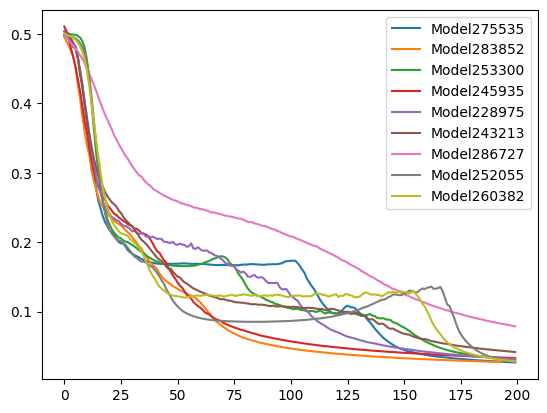

In [87]:
plot_history(histories)